#Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load data
data = pd.read_csv('/content/augmented_money_amounts.csv')

data

,target_text,input_text
0,zero,0ero
1,zero,zero
2,zero,zero
3,zero,z room ero
4,"four lakh, twenty-eight thousand, seven hundre...","four lakh, twenty-eight thousand, eeven hundre..."
...,...,...
3995,"nine crore, ninety-eight lakh","nine crore, ninety-ei week ght lakh"
3996,"nine crore, ninety-nine lakh","nine crore, niiety-nine lakh"
3997,"nine crore, ninety-nine lakh","nine crore, ninety-nine lakh"
3998,"nine crore, ninety-nine lakh","nine crore, ninety-nine lakh"


In [ ]:
data.describe()

,target_text,input_text
count,4000,4000
unique,1000,3659
top,zero,"eight crore, sixty lakh"
freq,4,3


#Prepare Dataset

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare texts
correct_texts = data['target_text'].astype(str).tolist()
erroneous_texts = data['input_text'].astype(str).tolist()

# Tokenize texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(correct_texts + erroneous_texts)

# Convert texts to sequences
correct_sequences = tokenizer.texts_to_sequences(correct_texts)
erroneous_sequences = tokenizer.texts_to_sequences(erroneous_texts)

# Determine the maximum sequence length for padding
max_sequence_length = max(max(len(seq) for seq in correct_sequences), max(len(seq) for seq in erroneous_sequences))

# Apply padding to sequences
correct_sequences_padded = pad_sequences(correct_sequences, maxlen=max_sequence_length, padding='post')
erroneous_sequences_padded = pad_sequences(erroneous_sequences, maxlen=max_sequence_length, padding='post')

# Shift the target sequences
correct_sequences_shifted = np.zeros_like(correct_sequences_padded)
correct_sequences_shifted[:, :-1] = correct_sequences_padded[:, 1:]

# Add a dimension at the end of target sequences
correct_sequences_shifted = correct_sequences_shifted[:, :, np.newaxis]


Create and train the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Layer

import re
#function to clean up the text
def clean_text(text):
    text = text.replace('\n', '')
    text = text.replace('_', '')
    text = text.replace('.', '')   # Remplace les retours à la ligne par un espace
    return re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', text)).strip()

#function to convert numerical amounts to words in Hindis
def number_to_hindi_words(amount):
    words = num2words(amount, lang='en_IN')
    return words




In [ ]:
class AttentionLayer(Layer):
    def call(self, decoder_outputs, encoder_outputs):
        # Compute attention scores
        scores = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Compute context vector
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        # Concatenate context vector with decoder outputs
        combined_context = tf.concat([context_vector, decoder_outputs], axis=-1)
        return combined_context

In [ ]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
latent_dim = 512

# Define the encoder
encoder_inputs = Input(shape=(max_sequence_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(max_sequence_length,))
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism:attention layer to enhance the model's ability to focus on relevant parts of the input sequence
attention_layer = AttentionLayer()
decoder_combined_context = attention_layer(decoder_outputs, encoder_outputs)

# Dense layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    [erroneous_sequences_padded, correct_sequences_padded],
    correct_sequences_shifted,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

# Save the model in the native Keras format
model.save('seq2seq_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 15, 256)        │        371,456 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 15)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 15, 256)        │        371,456 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 15, 512),      │      1,574,912 │ embedding[0][0],       │
│                           │ (None, 512), (None,    │                │ not_equal[0][0]        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 15, 512),      │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 15, 1024)       │              0 │ lstm_1[0][0],          │
│ (AttentionLayer)          │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15, 1451)       │      1,487,275 │ attention_layer[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,380,011 (20.52 MB)

 Trainable params: 5,380,011 (20.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6122 - loss: 3.5328 - val_accuracy: 0.8764 - val_loss: 0.5116
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7991 - loss: 0.7904 - val_accuracy: 0.8928 - val_loss: 0.3398
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8202 - loss: 0.5953 - val_accuracy: 0.8970 - val_loss: 0.3038
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8357 - loss: 0.4963 - val_accuracy: 0.8994 - val_loss: 0.2920
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8437 - loss: 0.4633 - val_accuracy: 0.9071 - val_loss: 0.2969
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8795 - loss: 0.3905 - val_accuracy: 0.9490 - val_loss: 0.2004
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9218 - loss: 0.2800 - val_accuracy: 0.9775 - val_loss: 0.1045
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9572 - loss: 0.1655 - val_accuracy: 0.9829 - v

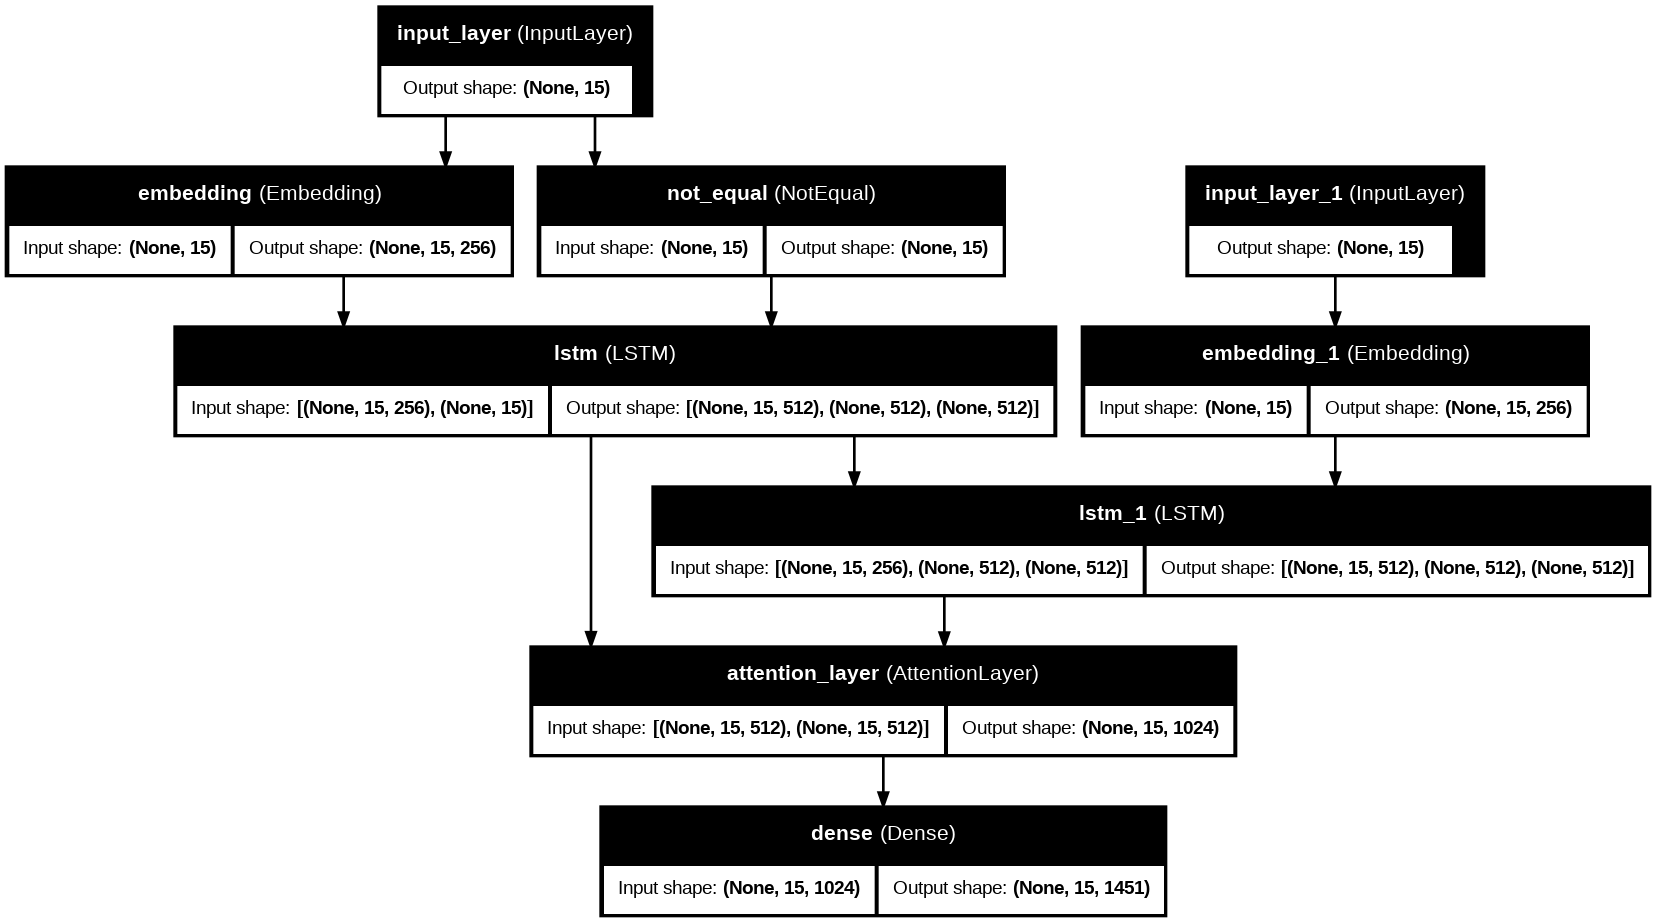

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

#Evaluate the model

In [ ]:
# Train the model
history = model.fit(
    [erroneous_sequences_padded, correct_sequences_padded],
    correct_sequences_shifted,
    batch_size=64,
    epochs=10,
    validation_split=0.2  # Use 20% of the data for validation
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9907 - loss: 0.0465 - val_accuracy: 0.9912 - val_loss: 0.0433
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9947 - loss: 0.0267 - val_accuracy: 0.9909 - val_loss: 0.0422
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9966 - loss: 0.0194 - val_accuracy: 0.9910 - val_loss: 0.0403
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9976 - loss: 0.0165 - val_accuracy: 0.9913 - val_loss: 0.0410
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9987 - loss: 0.0119 - val_accuracy: 0.9903 - val_loss: 0.0437
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9980 - loss: 0.0131 - val_accuracy: 0.9898 - val_loss: 0.0454
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9988 - loss: 0.0117 - val_accuracy: 0.9918 - val_loss: 0.0406
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9991 - loss: 0.0086 - val_accuracy: 0.9902 - val

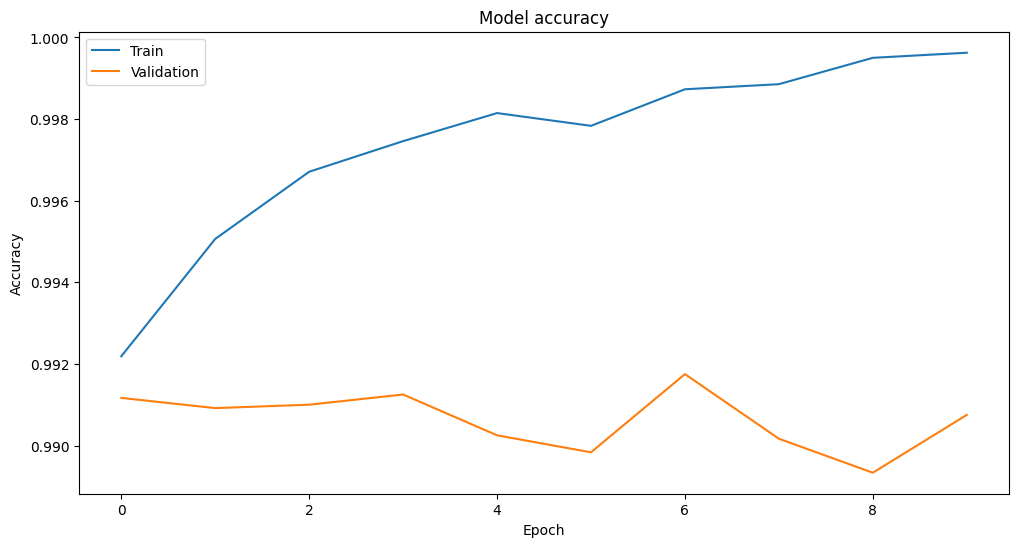

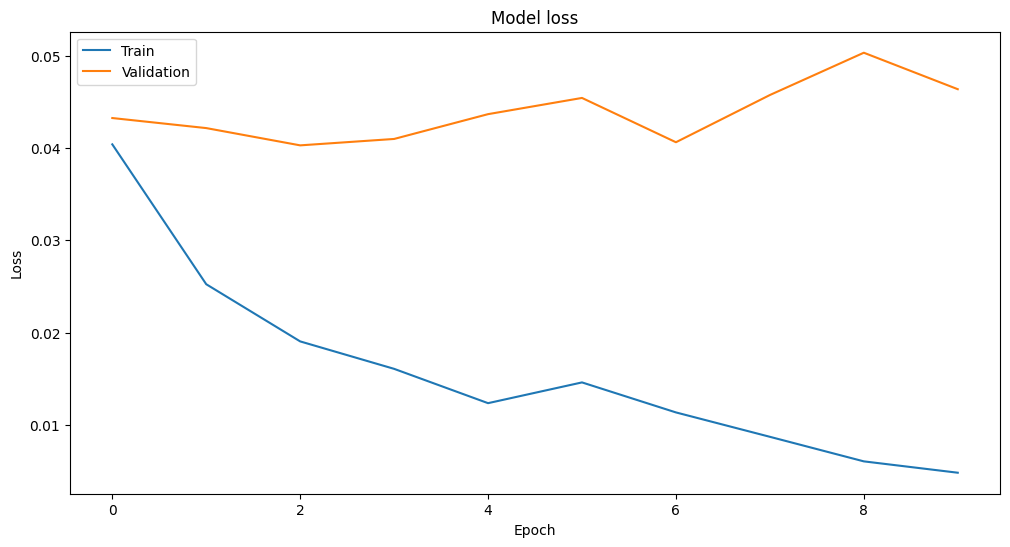

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `data` is your original DataFrame
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
# Prepare test texts
test_correct_texts = test_data['target_text'].astype(str).tolist()
test_erroneous_texts = test_data['input_text'].astype(str).tolist()

# Convert test texts to sequences using the same tokenizer
test_correct_sequences = tokenizer.texts_to_sequences(test_correct_texts)
test_erroneous_sequences = tokenizer.texts_to_sequences(test_erroneous_texts)

# Apply padding to sequences
test_correct_sequences_padded = pad_sequences(test_correct_sequences, maxlen=max_sequence_length, padding='post')
test_erroneous_sequences_padded = pad_sequences(test_erroneous_sequences, maxlen=max_sequence_length, padding='post')

# Shift the target sequences for the test set
test_correct_sequences_shifted = np.zeros_like(test_correct_sequences_padded)
test_correct_sequences_shifted[:, :-1] = test_correct_sequences_padded[:, 1:]

# Add a dimension at the end of the target sequences for the test set
test_correct_sequences_shifted = test_correct_sequences_shifted[:, :, np.newaxis]


In [ ]:
test_loss, test_accuracy = model.evaluate(
    [test_erroneous_sequences_padded, test_correct_sequences_padded],
    test_correct_sequences_shifted
)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9982 - loss: 0.0129
Test Loss: 0.010526585392653942
Test Accuracy: 0.9984167218208313


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1
# Get the predictions from the model
y_pred = model.predict([test_erroneous_sequences_padded, test_correct_sequences_padded])

# Assuming y_true is the actual target sequences from test_correct_sequences_shifted
# You may need to reshape y_pred and y_true appropriately before comparison

y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
y_true_flat = test_correct_sequences_shifted.flatten()

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true_flat, y_pred_flat)


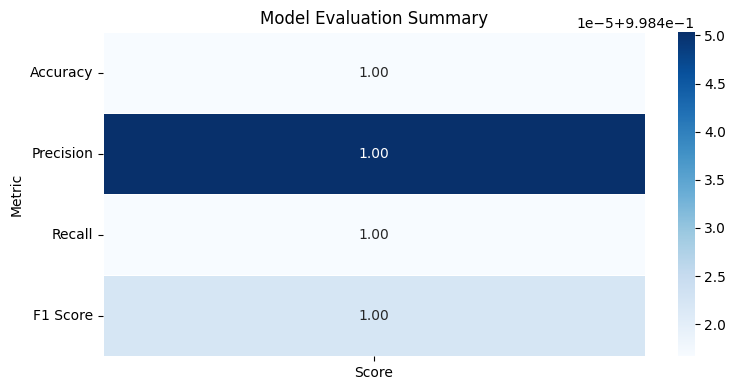

In [ ]:
# Create a DataFrame for the summary
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
}

df_summary = pd.DataFrame(summary_data).set_index('Metric')
import seaborn as sns
# Create a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_summary, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

# Set title and labels
plt.title('Model Evaluation Summary')
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal

# Display the plot
plt.tight_layout()
plt.show()